In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime

In [3]:
# 1. Đọc dữ liệu từ CSV
filename = "D:\\visua stiudio xanh\\hocki_3\\laptirnh_py\\K215480106043_NguyenVanSong_BaiTap-KhoaHocDuLieu_21-4\\bai3\\Data_Number_6.csv"
times = []
coordinates = []
vehicle_types = []
speeds = []
traffic_density = []

# Đọc dữ liệu từ CSV
with open(filename, mode='r') as file:
    csv_reader = csv.reader(file)
    header = next(csv_reader)  # Bỏ qua dòng tiêu đề
    for row in csv_reader:
        times.append(datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S'))
        coordinates.append([float(row[1]), float(row[2])])
        vehicle_types.append(row[3])
        speeds.append(float(row[4]))
        traffic_density.append(row[5])

# Chuyển tọa độ thành numpy array để xử lý
coordinates = np.array(coordinates)

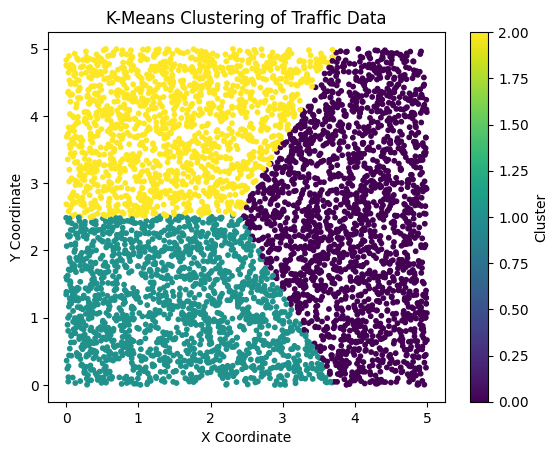

In [4]:
# 2. Phân cụm dữ liệu bằng K-Means
X_for_clustering = np.column_stack([coordinates[:, 0], coordinates[:, 1]])

# Áp dụng K-Means để phân cụm
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_for_clustering)

# Vẽ kết quả phân cụm
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=labels, cmap='viridis', s=10)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('K-Means Clustering of Traffic Data')
plt.colorbar(label='Cluster')
plt.show()

In [6]:
# 3. Tính toán chỉ số mức độ nghiêm trọng của tắc nghẽn
def calculate_congestion_severity(speed, density):
    """
    Mức độ nghiêm trọng của tắc nghẽn:
    - Mật độ giao thông cao và tốc độ thấp -> Tắc nghẽn nghiêm trọng
    """
    if density == 'high' and speed < 20:
        return 'Severe'
    elif density == 'medium' and speed < 30:
        return 'Moderate'
    else:
        return 'Low'

# Tính mức độ nghiêm trọng của tắc nghẽn cho mỗi bản ghi
congestion_severity = [calculate_congestion_severity(s, d) for s, d in zip(speeds, traffic_density)]

In [7]:
# 4. Tạo đặc trưng "giờ cao điểm"
def is_peak_hour(time):
    # Giả định giờ cao điểm từ 7:00 AM đến 9:00 AM và 5:00 PM đến 7:00 PM
    return 7 <= time.hour <= 9 or 17 <= time.hour <= 19

# Tạo cột giờ cao điểm
peak_hour = [1 if is_peak_hour(time) else 0 for time in times]

In [8]:
# 5. Tạo đặc trưng "tỷ lệ xe lớn" (ô tô và xe buýt)
def vehicle_ratio(vehicle_types):
    total_vehicles = len(vehicle_types)
    large_vehicles = sum([1 for v in vehicle_types if v in ['car', 'bus']])
    return large_vehicles / total_vehicles

# Tính tỷ lệ xe lớn cho mỗi bản ghi
vehicle_ratio_values = [vehicle_ratio(vehicle_types[i:i+1]) for i in range(len(vehicle_types))]


Accuracy of Gradient Boosting Model: 32.80%


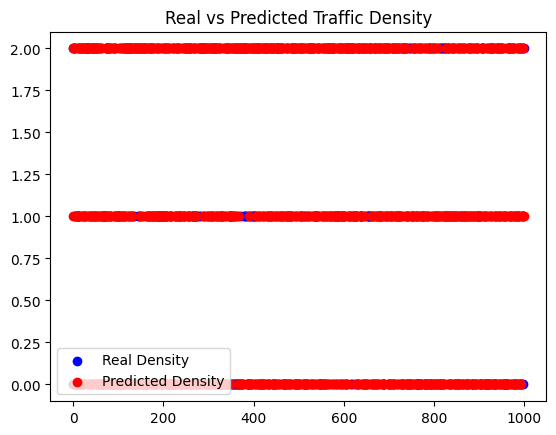

In [10]:
# 6. Xây dựng mô hình Gradient Boosting để dự đoán mật độ giao thông
# Tạo các đặc trưng
features = np.column_stack([np.array(speeds), peak_hour, vehicle_ratio_values])

# Chuyển đổi mật độ giao thông thành các nhãn phân loại (low=0, medium=1, high=2)
traffic_density_labels = {'low': 0, 'medium': 1, 'high': 2}
labels_traffic = [traffic_density_labels[d.lower()] for d in traffic_density]

# Chia dữ liệu thành train và test (80-20%)
train_size = int(0.8 * len(features))
X_train, X_test = features[:train_size], features[train_size:]
y_train, y_test = labels_traffic[:train_size], labels_traffic[train_size:]

# Khởi tạo và huấn luyện mô hình Gradient Boosting
model = GradientBoostingClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Dự đoán mật độ giao thông
y_pred = model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Gradient Boosting Model: {accuracy * 100:.2f}%")

# Vẽ biểu đồ so sánh giữa mật độ giao thông thực tế và dự đoán
plt.scatter(range(len(y_test)), y_test, color='blue', label='Real Density')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Density')
plt.legend()
plt.title('Real vs Predicted Traffic Density')
plt.show()